# Analytic Green's function in a 2d/3d sphere

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device('cuda:0')

# Dataset generation

# 1. 2D polar grid

In [150]:
grid_size = 50  # 그리드의 크기

Nx = grid_size                                                   # Number of samples
Ny = grid_size                                                   # Number of samples
x = torch.linspace(-1, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(-1, 1, Ny)                             # Input data for y (N x 1)
xy = torch.meshgrid(x,y)
xy_cartesian = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)
xy_polar = xy_cartesian[torch.sqrt(xy_cartesian[:,0]**2 + xy_cartesian[:,1]**2) <= 1]
xy_grid = xy_polar
eps = 1./grid_size #loss function에서 soft하게 컨디션 적용?
xy_bdry = xy_cartesian[torch.abs(torch.sqrt(xy_cartesian[:,0]**2 + xy_cartesian[:,1]**2) - 1.0) < eps]

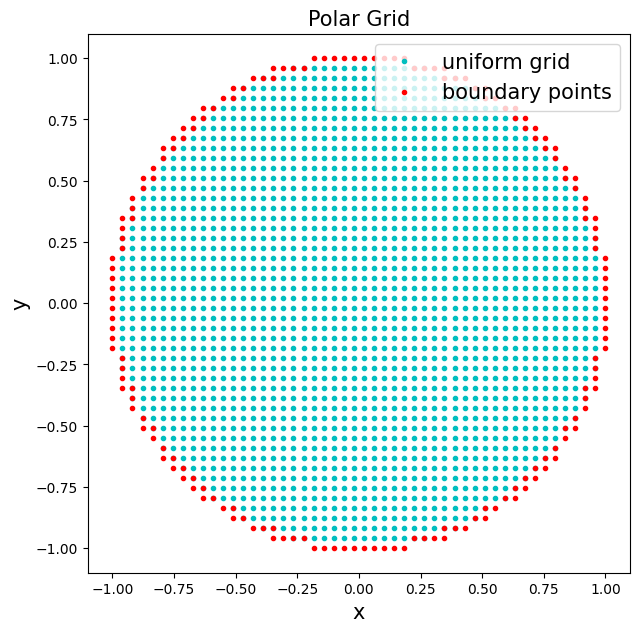

In [151]:
plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Polar Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

# True Green's function

In [186]:
import matplotlib.pyplot as plt
import torch
from scipy.special import jn, jn_zeros
import time

r_2 = torch.tensor(0.3)
theta_2 = torch.tensor(0.0)
k = 0.005

def true_green_disk(r, theta, r_2, theta_2):
    N_cutoff = 100
    M_cutoff = 500
    def create_zeros_n(n):
        return jn_zeros(n,M_cutoff)

    def eigenfunction_disk(r, theta, n, m, zero):
        coefficient = 2. / jn(n + 1, zero)**2
        return (coefficient * jn(n, zero*r) * torch.exp(1j * n * theta)).clone().detach()
        
    value = 0
    for n in range(-N_cutoff, N_cutoff + 1):
        z_nm = create_zeros_n(abs(n))
        for m in range(1, M_cutoff):
            zero = z_nm[m - 1]
            eigenvalue_disk = -zero**2 + k**2
            value = value + torch.conj(eigenfunction_disk(r, theta, n, m, zero))*eigenfunction_disk(r_2, theta_2, n, m, zero)/eigenvalue_disk

    return value.clone().detach()

In [187]:
xy_detach = xy_grid.cpu().detach()
xx = xy_detach[:,0]
yy = xy_detach[:,1]

r = torch.sqrt(xx**2 + yy**2)
theta = torch.atan2(yy, xx)

start = time.time()
zz_true = true_green_disk(r, theta, r_2, theta_2)
print(f"{time.time()-start:.4f} sec")

806.6770 sec


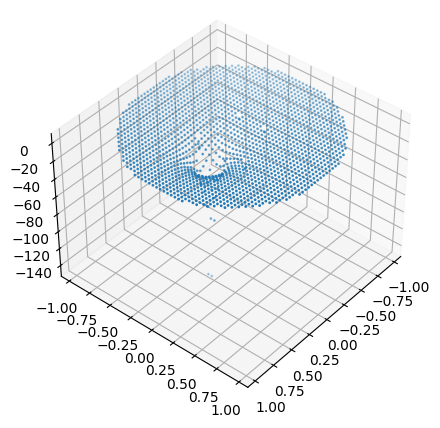

In [188]:

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=40., azim=40)
ax.scatter(xx, yy, zz_true, s=1)
plt.show()

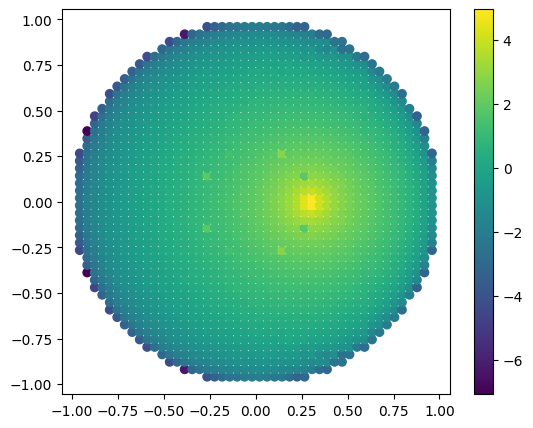

In [189]:
sizeparam = 5
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xx, yy, c= torch.log(-zz_true))
plt.colorbar()
plt.show()